# Sponsored Liquidity Rewards: Jesus Market Case Study

Analysis notebook for [https://telonex.io/research/sponsored-liquidity-rewards-jesus-market](https://telonex.io/research/sponsored-liquidity-rewards-jesus-market).

**Market:** `will-jesus-christ-return-before-2027`

**Data:** on-chain fills (Nov 25, 2025 - Feb 20, 2026), CLOB trades/quotes/book snapshots (Jan 19 - Feb 20, 2026).

In [15]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm

from dotenv import load_dotenv, find_dotenv
from telonex import get_dataframe, get_markets_dataframe

pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 160)
pd.options.display.float_format = '{:,.6f}'.format

# Telonex brand palette from repo conventions
TEAL = '#0C5B44'
CYAN = '#2DD4BF'
DARK = '#0F1929'
LIGHT_BG = '#F0F4F9'
MUTED = '#6B7280'
GREEN = '#10B981'
RED = '#EF4444'
AMBER = '#F59E0B'

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.size': 11,
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'axes.edgecolor': MUTED,
    'axes.labelcolor': DARK,
    'xtick.color': MUTED,
    'ytick.color': MUTED,
    'text.color': DARK,
})

_env = find_dotenv(usecwd=True)
ROOT = Path(_env).parent if _env else Path('.').resolve()
load_dotenv(_env)

API_KEY = os.environ['TELONEX_API_KEY']
_dl = os.environ.get('TELONEX_DOWNLOAD_DIR', './datasets')
DOWNLOAD_DIR = str((ROOT / _dl).resolve()) if not os.path.isabs(_dl) else _dl
OUT = Path('output').resolve()
OUT.mkdir(parents=True, exist_ok=True)

MAIN_SLUG = 'will-jesus-christ-return-before-2027'

TRADE_TO = '2026-02-21'      # exclusive upper bound -> includes Feb 20
QUOTE_TO = '2026-02-21'      # exclusive upper bound -> includes Feb 20
BOOK_TO = '2026-02-21'       # exclusive upper bound -> includes Feb 20
FILL_TO = '2026-02-21'       # exclusive upper bound -> includes Feb 20

In [16]:
def canonical_side(df: pd.DataFrame, side_col: str, asset_col: str) -> np.ndarray:
    same_asset = df[asset_col] == df['asset_id']
    return np.where(same_asset, df[side_col], np.where(df[side_col] == 'buy', 'sell', 'buy'))


def style_ax(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(0.99, 0.01, 'telonex.io', transform=ax.transAxes, ha='right', va='bottom', fontsize=9, color=MUTED, style='italic')


markets = get_markets_dataframe(exchange='polymarket', download_dir=DOWNLOAD_DIR)
main_market = markets[markets['slug'] == MAIN_SLUG].iloc[0]

YES_ASSET = main_market['asset_id_0']

coverage = pd.DataFrame([
    ('trades', main_market.get('trades_from'), main_market.get('trades_to')),
    ('quotes', main_market.get('quotes_from'), main_market.get('quotes_to')),
    ('book_snapshot_25', main_market.get('book_snapshot_25_from'), main_market.get('book_snapshot_25_to')),
    ('onchain_fills', main_market.get('onchain_fills_from'), main_market.get('onchain_fills_to')),
], columns=['channel', 'from_date', 'to_date_exclusive'])

fills_main = get_dataframe(
    api_key=API_KEY,
    exchange='polymarket',
    channel='onchain_fills',
    slug=MAIN_SLUG,
    outcome='Yes',
    from_date='2025-11-25',
    to_date=FILL_TO,
    download_dir=DOWNLOAD_DIR,
    engine='pandas',
)

trades_main = get_dataframe(
    api_key=API_KEY,
    exchange='polymarket',
    channel='trades',
    slug=MAIN_SLUG,
    outcome='Yes',
    from_date='2026-01-19',
    to_date=TRADE_TO,
    download_dir=DOWNLOAD_DIR,
    engine='pandas',
)

quotes_main = get_dataframe(
    api_key=API_KEY,
    exchange='polymarket',
    channel='quotes',
    slug=MAIN_SLUG,
    outcome='Yes',
    from_date='2026-01-19',
    to_date=QUOTE_TO,
    download_dir=DOWNLOAD_DIR,
    engine='pandas',
)

book_main = get_dataframe(
    api_key=API_KEY,
    exchange='polymarket',
    channel='book_snapshot_25',
    slug=MAIN_SLUG,
    outcome='Yes',
    from_date='2026-01-19',
    to_date=BOOK_TO,
    download_dir=DOWNLOAD_DIR,
    engine='pandas',
)

# Type conversions
for df in [fills_main]:
    df['timestamp'] = pd.to_datetime(df['block_timestamp_us'], unit='us', utc=True)
    df['date'] = df['timestamp'].dt.date
    df['price_raw'] = pd.to_numeric(df['price'], errors='coerce')
    df['amount'] = pd.to_numeric(df['amount'], errors='coerce')
    df['taker_cs'] = canonical_side(df, 'taker_side', 'taker_asset_id')
    df['maker_cs'] = canonical_side(df, 'maker_side', 'maker_asset_id')
    # In Telonex onchain_fills, row price is already canonical to row asset_id.
    df['price'] = df['price_raw']
    # Participant execution price: what taker/maker actually paid for their traded token.
    df['taker_exec_price'] = np.where(df['taker_asset_id'] == df['asset_id'], df['price'], 1.0 - df['price'])
    df['maker_exec_price'] = np.where(df['maker_asset_id'] == df['asset_id'], df['price'], 1.0 - df['price'])
    # Keep both notions: row-canonical YES notional and participant execution notional.
    df['usdc_vol_yes'] = df['price'] * df['amount']
    df['usdc_vol_taker'] = df['taker_exec_price'] * df['amount']
    df['usdc_vol_maker'] = df['maker_exec_price'] * df['amount']
    # Default "volume" in this notebook = gross taker-paid notional.
    df['usdc_vol'] = df['usdc_vol_taker']

trades_main['timestamp'] = pd.to_datetime(trades_main['timestamp_us'], unit='us', utc=True)
trades_main['date'] = trades_main['timestamp'].dt.date
trades_main['price'] = pd.to_numeric(trades_main['price'], errors='coerce')
trades_main['size'] = pd.to_numeric(trades_main['size'], errors='coerce')
trades_main['usdc_vol'] = trades_main['price'] * trades_main['size']

quotes_main['timestamp'] = pd.to_datetime(quotes_main['timestamp_us'], unit='us', utc=True)
quotes_main['date'] = quotes_main['timestamp'].dt.date
for col in ['bid_price', 'ask_price', 'bid_size', 'ask_size']:
    quotes_main[col] = pd.to_numeric(quotes_main[col], errors='coerce')
quotes_main['spread'] = quotes_main['ask_price'] - quotes_main['bid_price']
quotes_main['mid'] = (quotes_main['ask_price'] + quotes_main['bid_price']) / 2
quotes_main = quotes_main.sort_values('timestamp')

book_main['timestamp'] = pd.to_datetime(book_main['timestamp_us'], unit='us', utc=True)
book_main['date'] = book_main['timestamp'].dt.date
for i in range(25):
    for side in ['bid', 'ask']:
        p_col = f'{side}_price_{i}'
        s_col = f'{side}_size_{i}'
        book_main[p_col] = pd.to_numeric(book_main[p_col], errors='coerce')
        book_main[s_col] = pd.to_numeric(book_main[s_col], errors='coerce').fillna(0)
# Defragment after many per-column assignments to avoid pandas PerformanceWarning later.
book_main = book_main.copy()

bid_size_cols = [f'bid_size_{i}' for i in range(25)]
ask_size_cols = [f'ask_size_{i}' for i in range(25)]
book_main['top_depth'] = book_main['bid_size_0'] + book_main['ask_size_0']
book_main['depth25'] = book_main[bid_size_cols].sum(axis=1) + book_main[ask_size_cols].sum(axis=1)
book_main['spread'] = book_main['ask_price_0'] - book_main['bid_price_0']
book_main['mid'] = (book_main['ask_price_0'] + book_main['bid_price_0']) / 2
book_main = book_main.sort_values('timestamp')

print('Loaded rows:')
print(f'  fills_main:   {len(fills_main):,} | {fills_main.timestamp.min()} -> {fills_main.timestamp.max()}')
print(f'  trades_main:  {len(trades_main):,} | {trades_main.timestamp.min()} -> {trades_main.timestamp.max()}')
print(f'  quotes_main:  {len(quotes_main):,} | {quotes_main.timestamp.min()} -> {quotes_main.timestamp.max()}')
print(f'  book_main:    {len(book_main):,} | {book_main.timestamp.min()} -> {book_main.timestamp.max()}')

coverage

Loaded rows:
  fills_main:   80,208 | 2025-11-25 18:41:03+00:00 -> 2026-02-20 23:59:44+00:00
  trades_main:  51,123 | 2026-01-19 00:29:28.468000+00:00 -> 2026-02-20 23:59:40.689000+00:00
  quotes_main:  109,601 | 2026-01-19 00:29:28.439000+00:00 -> 2026-02-20 23:59:54.728000+00:00
  book_main:    384,685 | 2026-01-19 00:29:28.439000+00:00 -> 2026-02-20 23:59:54.728000+00:00


,channel,from_date,to_date_exclusive
0,trades,2026-01-19,2026-02-22
1,quotes,2026-01-19,2026-02-22
2,book_snapshot_25,2026-01-19,2026-02-22
3,onchain_fills,2025-11-25,2026-02-22


## Data, Scope, and Method

We combine `onchain_fills`, `trades`, `quotes`, and `book_snapshot_25`, then:
- canonicalize fill-side direction (using taker/maker canonical side; row price is canonical to `asset_id` in Telonex onchain_fills)
- compute volume in participant terms via execution price (`taker_exec_price`) for gross taker-paid notional
- detect the Feb 17 structural break from tick-level depth jumps
- compare pre/post regimes for depth, impact, fill intensity, execution cost, and maker structure
- evaluate execution by USDC budgets for both YES buys and mirrored NO buys
- profile wallet behavior, concentration, and cohort outcomes

In [17]:
# Detect structural break time on Feb 17 from tick-to-tick depth jumps
feb17 = book_main[(book_main['timestamp'] >= pd.Timestamp('2026-02-17', tz='UTC')) & (book_main['timestamp'] < pd.Timestamp('2026-02-18', tz='UTC'))].sort_values('timestamp').copy()
feb17['jump_ratio'] = feb17['depth25'] / feb17['depth25'].shift(1)
event_ts = feb17.loc[feb17['jump_ratio'].idxmax(), 'timestamp']

# Two regimes for broader comparison
pre_regime_start = pd.Timestamp('2026-02-10', tz='UTC')
pre_regime_end = event_ts
post_regime_start = pd.Timestamp('2026-02-18', tz='UTC')
post_regime_end = pd.Timestamp('2026-02-21', tz='UTC')

# 24h event window for immediate before/after impact
event_pre_start = event_ts - pd.Timedelta('24h')
event_post_end = event_ts + pd.Timedelta('24h')

print('Detected structural break (max tick-to-tick depth jump):', event_ts)

def in_window(df, start, end, ts_col='timestamp'):
    return df[(df[ts_col] >= start) & (df[ts_col] < end)]

fills_pre = in_window(fills_main, pre_regime_start, pre_regime_end)
fills_post = in_window(fills_main, post_regime_start, post_regime_end)

quotes_pre = in_window(quotes_main, pre_regime_start, pre_regime_end)
quotes_post = in_window(quotes_main, post_regime_start, post_regime_end)

book_pre = in_window(book_main, pre_regime_start, pre_regime_end)
book_post = in_window(book_main, post_regime_start, post_regime_end)

# Daily aggregates
daily_price = trades_main.groupby('date').agg(
    vwap=('price', lambda x: np.average(x, weights=trades_main.loc[x.index, 'size'])),
    volume=('usdc_vol', 'sum'),
    fills=('price', 'count'),
    min_price=('price', 'min'),
    max_price=('price', 'max'),
).sort_index()

daily_fills = fills_main.groupby('date').agg(
    onchain_volume=('usdc_vol', 'sum'),
    onchain_fills=('usdc_vol', 'count'),
    unique_wallets=('maker', lambda x: len(set(x) | set(fills_main.loc[x.index, 'taker']))),
).sort_index()

# Wallet first-seen / growth
maker_first = fills_main.groupby('maker')['date'].min().rename('first_date')
taker_first = fills_main.groupby('taker')['date'].min().rename('first_date')
wallet_first = pd.concat([
    maker_first.rename_axis('wallet').reset_index(),
    taker_first.rename_axis('wallet').reset_index(),
]).groupby('wallet')['first_date'].min()

new_wallets_daily = wallet_first.value_counts().sort_index().rename('new_wallets').to_frame()
new_wallets_daily['cum_wallets'] = new_wallets_daily['new_wallets'].cumsum()

# Position + mark-to-market by wallet
def wallet_book(df):
    pos = {}
    cash = {}
    first = {}
    for row in df[['timestamp', 'maker', 'taker', 'amount', 'price', 'maker_cs', 'taker_cs']].itertuples(index=False):
        ts, maker, taker, amount, price, maker_cs, taker_cs = row
        first.setdefault(maker, ts.date())
        first.setdefault(taker, ts.date())

        if taker_cs == 'buy':
            pos[taker] = pos.get(taker, 0.0) + amount
            cash[taker] = cash.get(taker, 0.0) - amount * price
        else:
            pos[taker] = pos.get(taker, 0.0) - amount
            cash[taker] = cash.get(taker, 0.0) + amount * price

        if maker_cs == 'buy':
            pos[maker] = pos.get(maker, 0.0) + amount
            cash[maker] = cash.get(maker, 0.0) - amount * price
        else:
            pos[maker] = pos.get(maker, 0.0) - amount
            cash[maker] = cash.get(maker, 0.0) + amount * price

    out = pd.DataFrame({'wallet': list(pos.keys())})
    out['pos'] = out['wallet'].map(pos)
    out['cash'] = out['wallet'].map(cash)
    out['first_date'] = out['wallet'].map(first)
    return out

wallet_state = wallet_book(fills_main)

last_mid = quotes_main.sort_values('timestamp')['mid'].dropna().iloc[-1]
wallet_state['pnl_marked'] = wallet_state['cash'] + wallet_state['pos'] * last_mid
wallet_state['abs_cash'] = wallet_state['cash'].abs()

long_wallets = wallet_state[wallet_state['pos'] > 0].sort_values('pos', ascending=False)
short_wallets = wallet_state[wallet_state['pos'] < 0].sort_values('pos')

# Maker concentration by day
maker_day = fills_main.groupby(['date', 'maker'])['usdc_vol_maker'].sum().reset_index()
conc_rows = []
for d, g in maker_day.groupby('date'):
    total = g['usdc_vol_maker'].sum()
    w = (g['usdc_vol_maker'] / total).values if total > 0 else np.array([0.0])
    hhi = float((w ** 2).sum()) if total > 0 else np.nan
    top5 = float(g['usdc_vol_maker'].sort_values(ascending=False).head(5).sum() / total) if total > 0 else np.nan
    conc_rows.append((d, hhi, top5, g['maker'].nunique()))

maker_conc = pd.DataFrame(conc_rows, columns=['date', 'hhi', 'top5_share', 'maker_count']).set_index('date').sort_index()

# Additional depth aggregates: first N levels
book_main['depth5'] = book_main[[f'bid_size_{i}' for i in range(5)]].sum(axis=1) + book_main[[f'ask_size_{i}' for i in range(5)]].sum(axis=1)
book_main['depth10'] = book_main[[f'bid_size_{i}' for i in range(10)]].sum(axis=1) + book_main[[f'ask_size_{i}' for i in range(10)]].sum(axis=1)

# Cost to move by 1 cent up/down from top of book
def cost_to_move_up_1c(row):
    best_ask = row['ask_price_0']
    if pd.isna(best_ask):
        return np.nan
    target = best_ask + 0.01
    cost = 0.0
    touched = False
    for i in range(25):
        p = row[f'ask_price_{i}']
        s = row[f'ask_size_{i}']
        if pd.isna(p) or s <= 0:
            continue
        if p <= target + 1e-12:
            cost += p * s
            touched = True
        else:
            break
    return cost if touched else np.nan

def proceeds_to_move_down_1c(row):
    best_bid = row['bid_price_0']
    if pd.isna(best_bid):
        return np.nan
    target = best_bid - 0.01
    proceeds = 0.0
    touched = False
    for i in range(25):
        p = row[f'bid_price_{i}']
        s = row[f'bid_size_{i}']
        if pd.isna(p) or s <= 0:
            continue
        if p >= target - 1e-12:
            proceeds += p * s
            touched = True
        else:
            break
    return proceeds if touched else np.nan

book_main['cost_up_1c'] = book_main.apply(cost_to_move_up_1c, axis=1)
book_main['proc_down_1c'] = book_main.apply(proceeds_to_move_down_1c, axis=1)
book_main = book_main.copy()

daily_move_cost = book_main.groupby('date')[['cost_up_1c', 'proc_down_1c']].median().sort_index()

# Cumulative depth curve by level (median across snapshots)
bid_sizes = book_main[[f'bid_size_{i}' for i in range(25)]].to_numpy(dtype=float)
ask_sizes = book_main[[f'ask_size_{i}' for i in range(25)]].to_numpy(dtype=float)
cum_depth = np.cumsum(bid_sizes, axis=1) + np.cumsum(ask_sizes, axis=1)
depth_curve_all = pd.DataFrame(cum_depth, columns=[f'level_{i}' for i in range(1, 26)])
depth_curve_all['timestamp'] = book_main['timestamp']

curve_pre = in_window(depth_curve_all, pre_regime_start, pre_regime_end).drop(columns=['timestamp']).median()
curve_post = in_window(depth_curve_all, post_regime_start, post_regime_end).drop(columns=['timestamp']).median()
depth_curve = pd.DataFrame({
    'level': np.arange(1, 26),
    'pre_depth': curve_pre.values,
    'post_depth': curve_post.values,
})
depth_curve['multiple'] = depth_curve['post_depth'] / depth_curve['pre_depth']

# Execution quality by USDC budget (YES and NO buys), computed directly on tick snapshots.
# NO-side buy is derived from mirrored YES bids: no_ask = 1 - yes_bid.
# We only have 25 displayed levels in this dataset, so high-budget curves naturally truncate.
ask_prices = book_main[[f'ask_price_{i}' for i in range(25)]].to_numpy(dtype=float)
bid_prices = book_main[[f'bid_price_{i}' for i in range(25)]].to_numpy(dtype=float)

def exec_vwap_by_budget(prices, sizes, budget):
    cnotional = np.cumsum(prices * sizes, axis=1)
    csize = np.cumsum(sizes, axis=1)
    fillable = cnotional[:, -1] >= budget
    first_idx = np.argmax(cnotional >= budget, axis=1)
    row_idx = np.arange(len(prices))
    prev_idx = np.clip(first_idx - 1, 0, prices.shape[1] - 1)
    prev_notional = np.where(first_idx > 0, cnotional[row_idx, prev_idx], 0.0)
    prev_size = np.where(first_idx > 0, csize[row_idx, prev_idx], 0.0)
    px = prices[row_idx, first_idx]
    residual_notional = budget - prev_notional
    residual_shares = residual_notional / px
    shares_out = prev_size + residual_shares
    vwap = budget / shares_out
    vwap[~fillable] = np.nan
    return vwap, fillable

no_ask_prices = 1.0 - bid_prices
no_ask_sizes = bid_sizes.copy()
budget_sizes = sorted(np.unique(np.round(np.geomspace(100, 150_000, 18)).astype(int)).tolist())
for budget in budget_sizes:
    yes_vwap, yes_fillable = exec_vwap_by_budget(ask_prices, ask_sizes, budget)
    no_vwap, no_fillable = exec_vwap_by_budget(no_ask_prices, no_ask_sizes, budget)
    yes_ref = book_main['ask_price_0'].to_numpy(dtype=float)
    no_ref = 1.0 - book_main['bid_price_0'].to_numpy(dtype=float)
    book_main[f'yes_buy_slip_bps_{budget}'] = np.where(np.isfinite(yes_vwap), (yes_vwap / yes_ref - 1.0) * 10_000, np.nan)
    book_main[f'no_buy_slip_bps_{budget}'] = np.where(np.isfinite(no_vwap), (no_vwap / no_ref - 1.0) * 10_000, np.nan)
    book_main[f'yes_buy_obs_share_{budget}'] = yes_fillable.astype(float)
    book_main[f'no_buy_obs_share_{budget}'] = no_fillable.astype(float)

exec_rows = []
for regime_name, b in [('pre', in_window(book_main, pre_regime_start, pre_regime_end)), ('post', in_window(book_main, post_regime_start, post_regime_end))]:
    for budget in budget_sizes:
        exec_rows.append({
            'regime': regime_name,
            'budget_usdc': budget,
            'yes_buy_slippage_bps': b[f'yes_buy_slip_bps_{budget}'].median(),
            'no_buy_slippage_bps': b[f'no_buy_slip_bps_{budget}'].median(),
            'yes_obs_share': b[f'yes_buy_obs_share_{budget}'].mean(),
            'no_obs_share': b[f'no_buy_obs_share_{budget}'].mean(),
        })
exec_summary = pd.DataFrame(exec_rows)

# Tick-level update intensity (counts divided by elapsed clock time)
pre_hours = (pre_regime_end - pre_regime_start).total_seconds() / 3600
post_hours = (post_regime_end - post_regime_start).total_seconds() / 3600

quote_rate = {
    'pre': len(quotes_pre) / pre_hours if pre_hours > 0 else np.nan,
    'post': len(quotes_post) / post_hours if post_hours > 0 else np.nan,
}
book_rate = {
    'pre': len(book_pre) / pre_hours if pre_hours > 0 else np.nan,
    'post': len(book_post) / post_hours if post_hours > 0 else np.nan,
}
fills_rate = {
    'pre': len(fills_pre) / pre_hours if pre_hours > 0 else np.nan,
    'post': len(fills_post) / post_hours if post_hours > 0 else np.nan,
}

# Tick-level flow impact lambda from fill event -> future quote mid (no downsampling)
quotes_for_asof = quotes_main[['timestamp', 'mid']].dropna().sort_values('timestamp')

def impact_lambda(fills_df, start, end, horizon_seconds):
    f = fills_df[(fills_df['timestamp'] >= start) & (fills_df['timestamp'] < end)][['timestamp', 'amount', 'taker_cs']].sort_values('timestamp').copy()
    if len(f) < 50:
        return np.nan
    f['signed_shares'] = np.where(f['taker_cs'] == 'buy', f['amount'], -f['amount'])
    base = pd.merge_asof(f[['timestamp']], quotes_for_asof, on='timestamp', direction='backward')
    future_ts = pd.DataFrame({'timestamp': f['timestamp'] + pd.Timedelta(seconds=horizon_seconds)})
    future = pd.merge_asof(future_ts, quotes_for_asof, on='timestamp', direction='forward')
    dmid_bp = (future['mid'].to_numpy() - base['mid'].to_numpy()) * 10_000
    valid = np.isfinite(dmid_bp) & np.isfinite(f['signed_shares'].to_numpy()) & (f['signed_shares'].to_numpy() != 0)
    if valid.sum() < 30:
        return np.nan
    x = f.loc[valid, 'signed_shares'].to_numpy()
    y = dmid_bp[valid]
    return float(np.linalg.lstsq(x.reshape(-1, 1), y, rcond=None)[0][0])

lambda5_pre = impact_lambda(fills_main, pre_regime_start, pre_regime_end, horizon_seconds=5)
lambda5_post = impact_lambda(fills_main, post_regime_start, post_regime_end, horizon_seconds=5)
lambda60_pre = impact_lambda(fills_main, pre_regime_start, pre_regime_end, horizon_seconds=60)
lambda60_post = impact_lambda(fills_main, post_regime_start, post_regime_end, horizon_seconds=60)

# Large-trade resilience: does top depth replenish after big prints?
fills_regime = fills_main[(fills_main['timestamp'] >= pre_regime_start) & (fills_main['timestamp'] < post_regime_end)].copy()
book_for_asof = book_main[['timestamp', 'top_depth']].sort_values('timestamp')
events = []
for label, start, end in [('pre', pre_regime_start, pre_regime_end), ('post', post_regime_start, post_regime_end)]:
    g = fills_regime[(fills_regime['timestamp'] >= start) & (fills_regime['timestamp'] < end)].copy()
    if g.empty:
        continue
    threshold = g['amount'].quantile(0.95)
    big = g[g['amount'] >= threshold].sort_values('timestamp').head(800)[['timestamp']].copy()
    if big.empty:
        continue

    d0 = pd.merge_asof(big, book_for_asof, on='timestamp', direction='backward')['top_depth']
    d30 = pd.merge_asof(big.assign(timestamp=big['timestamp'] + pd.Timedelta(seconds=30)), book_for_asof, on='timestamp', direction='forward')['top_depth']
    d120 = pd.merge_asof(big.assign(timestamp=big['timestamp'] + pd.Timedelta(seconds=120)), book_for_asof, on='timestamp', direction='forward')['top_depth']

    tmp = pd.DataFrame({
        'regime': label,
        'd0': d0.values,
        'd30': d30.values,
        'd120': d120.values,
    }).dropna()
    events.append(tmp)

resilience = pd.concat(events, ignore_index=True) if events else pd.DataFrame(columns=['regime', 'd0', 'd30', 'd120'])
resilience['chg30'] = (resilience['d30'] - resilience['d0']) / resilience['d0']
resilience['chg120'] = (resilience['d120'] - resilience['d0']) / resilience['d0']

main_wallets = set(fills_main['maker']) | set(fills_main['taker'])

# Rebuild windows after derived columns on book_main
book_pre = in_window(book_main, pre_regime_start, pre_regime_end)
book_post = in_window(book_main, post_regime_start, post_regime_end)

# Summary objects used later
regime_summary = pd.DataFrame([
    {
        'regime': 'Pre rewards (Feb 10 -> event)',
        'median_top_depth': book_pre['top_depth'].median(),
        'median_depth5': book_pre['depth5'].median(),
        'median_depth10': book_pre['depth10'].median(),
        'median_depth25': book_pre['depth25'].median(),
        'median_spread_cents': quotes_pre['spread'].median() * 100,
        'quotes_per_hour': quote_rate['pre'],
        'book_updates_per_hour': book_rate['pre'],
        'fills_per_hour': fills_rate['pre'],
        'median_cost_up_1c': book_pre['cost_up_1c'].median(),
        'median_proc_down_1c': book_pre['proc_down_1c'].median(),
        'lambda_5s_bp_per_share': lambda5_pre,
        'lambda_60s_bp_per_share': lambda60_pre,
    },
    {
        'regime': 'Post rewards (Feb 18-20)',
        'median_top_depth': book_post['top_depth'].median(),
        'median_depth5': book_post['depth5'].median(),
        'median_depth10': book_post['depth10'].median(),
        'median_depth25': book_post['depth25'].median(),
        'median_spread_cents': quotes_post['spread'].median() * 100,
        'quotes_per_hour': quote_rate['post'],
        'book_updates_per_hour': book_rate['post'],
        'fills_per_hour': fills_rate['post'],
        'median_cost_up_1c': book_post['cost_up_1c'].median(),
        'median_proc_down_1c': book_post['proc_down_1c'].median(),
        'lambda_5s_bp_per_share': lambda5_post,
        'lambda_60s_bp_per_share': lambda60_post,
    },
])

display(regime_summary)
display(exec_summary)

overall = {
    'main_volume': float(fills_main['usdc_vol'].sum()),
    'main_wallets': int(len(main_wallets)),
    'long_wallets': int((wallet_state['pos'] > 0).sum()),
    'short_wallets': int((wallet_state['pos'] < 0).sum()),
    'event_ts': event_ts,
    'last_mid': float(last_mid),
}
overall

Detected structural break (max tick-to-tick depth jump): 2026-02-17 23:31:12.355000+00:00


,regime,median_top_depth,median_depth5,median_depth10,median_depth25,median_spread_cents,quotes_per_hour,book_updates_per_hour,fills_per_hour,median_cost_up_1c,median_proc_down_1c,lambda_5s_bp_per_share,lambda_60s_bp_per_share
0,Pre rewards (Feb 10 -> event),"38,386.300000","361,222.930000","756,183.020000","1,468,279.570000",0.100000,337.745231,683.703700,216.389822,"19,820.531540","12,974.354620",0.000018,0.000164
1,Post rewards (Feb 18-20),"900,931.200000","4,466,198.380000","9,114,440.240000","22,068,638.100000",0.100000,476.694444,"2,631.305556",376.888889,"155,297.121570","164,589.343990",0.000016,0.000031


,regime,budget_usdc,yes_buy_slippage_bps,no_buy_slippage_bps,yes_obs_share,no_obs_share
0,pre,100,0.000000,0.000000,1.000000,1.000000
1,pre,154,0.000000,0.000000,1.000000,1.000000
2,pre,236,0.000000,0.000000,1.000000,1.000000
3,pre,363,0.000000,0.000000,1.000000,1.000000
4,pre,559,80.113425,0.000000,1.000000,1.000000
5,pre,859,142.012870,0.000000,1.000000,1.000000
6,pre,1321,186.824167,0.000000,1.000000,1.000000
7,pre,2031,223.536042,0.000000,1.000000,1.000000
8,pre,3123,291.650988,0.000000,1.000000,1.000000
9,pre,4802,422.556062,0.000000,1.000000,1.000000


{'main_volume': 11579704.912887394,
 'main_wallets': 13779,
 'long_wallets': 1522,
 'short_wallets': 8648,
 'event_ts': Timestamp('2026-02-17 23:31:12.355000+0000', tz='UTC'),
 'last_mid': 0.0365}

## Key Findings (Auto-Computed)

The cells below intentionally compute values from data each run to avoid stale hardcoded claims.

In [18]:
ratio_short_long = overall['short_wallets'] / max(overall['long_wallets'], 1)

pre_row = regime_summary.iloc[0]
post_row = regime_summary.iloc[1]

mul_depth5 = post_row['median_depth5'] / pre_row['median_depth5']
mul_depth10 = post_row['median_depth10'] / pre_row['median_depth10']
mul_depth25 = post_row['median_depth25'] / pre_row['median_depth25']
mul_top_depth = post_row['median_top_depth'] / pre_row['median_top_depth']
mul_cost_up = post_row['median_cost_up_1c'] / pre_row['median_cost_up_1c']
mul_cost_dn = post_row['median_proc_down_1c'] / pre_row['median_proc_down_1c']
lambda5_drop = abs(pre_row['lambda_5s_bp_per_share']) / max(abs(post_row['lambda_5s_bp_per_share']), 1e-12)
lambda60_drop = abs(pre_row['lambda_60s_bp_per_share']) / max(abs(post_row['lambda_60s_bp_per_share']), 1e-12)

feb18_new = wallet_state[wallet_state['first_date'] == pd.Timestamp('2026-02-18').date()]
feb18_new_active = feb18_new[feb18_new['abs_cash'] >= 100]
pre_active = wallet_state[(wallet_state['first_date'] <= pd.Timestamp('2026-02-16').date()) & (wallet_state['abs_cash'] >= 100)]

# Resilience summary
res_summary = resilience.groupby('regime').agg(
    events=('chg30', 'count'),
    median_chg30=('chg30', 'median'),
    median_chg120=('chg120', 'median'),
    pct_pos_30=('chg30', lambda x: (x > 0).mean()),
)

fills_last_day = fills_main['date'].max()
fills_last_day_hours = fills_main[fills_main['date'] == fills_last_day]['timestamp'].dt.hour.nunique()

print(f"1) Coverage: on-chain fills through {fills_main.date.max()}, CLOB data through {trades_main.date.max()}.")
print(f"2) Gross taker-paid on-chain volume: ${overall['main_volume']:,.0f} across {overall['main_wallets']:,} wallets.")
print(f"3) Market stance: {overall['long_wallets']:,} net-long vs {overall['short_wallets']:,} net-short wallets ({ratio_short_long:.2f}:1 skeptics-to-believers).")
print(f"4) Depth expansion by displayed levels: top={mul_top_depth:.1f}x, depth5={mul_depth5:.1f}x, depth10={mul_depth10:.1f}x, depth25={mul_depth25:.1f}x.")
print(f"5) Cost to move price by 1 cent increased {mul_cost_up:.1f}x upward and {mul_cost_dn:.1f}x downward.")
print(f"6) Flow-impact lambda dropped by ~{lambda5_drop:.1f}x at 5s and ~{lambda60_drop:.1f}x at 60s.")
epre = exec_summary[(exec_summary['regime'] == 'pre') & (exec_summary['budget_usdc'] == 100_000)]
epost = exec_summary[(exec_summary['regime'] == 'post') & (exec_summary['budget_usdc'] == 100_000)]
if len(epre) and len(epost) and pd.notna(epre['yes_buy_slippage_bps'].iloc[0]) and pd.notna(epost['yes_buy_slippage_bps'].iloc[0]):
    print(f"7) $100k YES slippage: {epre['yes_buy_slippage_bps'].iloc[0]:.2f} -> {epost['yes_buy_slippage_bps'].iloc[0]:.2f} bps; NO slippage: {epre['no_buy_slippage_bps'].iloc[0]:.2f} -> {epost['no_buy_slippage_bps'].iloc[0]:.2f} bps.")

if not res_summary.empty:
    for regime, row in res_summary.iterrows():
        print(f"8) Resilience ({regime}): median top-depth change {row['median_chg30']*100:+.2f}% at +30s, {row['median_chg120']*100:+.2f}% at +120s; replenish rate={row['pct_pos_30']*100:.1f}%.")

if len(feb18_new_active) > 0 and len(pre_active) > 0:
    print(f"9) Feb 18 new cohort median marked PnL ${feb18_new_active['pnl_marked'].median():,.2f} vs ${pre_active['pnl_marked'].median():,.2f} for pre-event cohort.")
if fills_last_day_hours < 24:
    print(f"Note: onchain_fills on {fills_last_day} is partial ({fills_last_day_hours}/24 hours).")

anchor_budgets = [100, 250, 500, 1_000, 2_500, 5_000, 10_000, 25_000, 50_000, 100_000, 150_000]
exec_show = exec_summary[exec_summary['budget_usdc'].isin(anchor_budgets)].sort_values(['budget_usdc', 'regime']).copy()
exec_show = exec_show[['regime', 'budget_usdc', 'yes_buy_slippage_bps', 'no_buy_slippage_bps', 'yes_obs_share', 'no_obs_share']]
exec_show['budget_usdc'] = exec_show['budget_usdc'].map(lambda x: f'{int(x):,}')
for c in ['yes_buy_slippage_bps', 'no_buy_slippage_bps']:
    exec_show[c] = exec_show[c].map(lambda x: f'{x:.2f}')
for c in ['yes_obs_share', 'no_obs_share']:
    exec_show[c] = exec_show[c].map(lambda x: f'{x*100:.1f}%')

print("10) Execution by USDC budget:")
display(exec_show)

1) Coverage: on-chain fills through 2026-02-20, CLOB data through 2026-02-20.
2) Gross taker-paid on-chain volume: $11,579,705 across 13,779 wallets.
3) Market stance: 1,522 net-long vs 8,648 net-short wallets (5.68:1 skeptics-to-believers).
4) Depth expansion by displayed levels: top=23.5x, depth5=12.4x, depth10=12.1x, depth25=15.0x.
5) Cost to move price by 1 cent increased 7.8x upward and 12.7x downward.
6) Flow-impact lambda dropped by ~1.1x at 5s and ~5.3x at 60s.
8) Resilience (post): median top-depth change +0.00% at +30s, +0.97% at +120s; replenish rate=49.9%.
8) Resilience (pre): median top-depth change -0.16% at +30s, +0.03% at +120s; replenish rate=27.3%.
9) Feb 18 new cohort median marked PnL $7.52 vs $30.10 for pre-event cohort.
10) Execution by USDC budget:


,regime,budget_usdc,yes_buy_slippage_bps,no_buy_slippage_bps,yes_obs_share,no_obs_share
18,post,100,0.00,-0.00,100.0%,100.0%
0,pre,100,0.00,0.00,100.0%,100.0%
35,post,"150,000",1473.78,0.00,100.0%,100.0%
17,pre,"150,000",1236.87,19.58,1.2%,100.0%


## Price and Volume

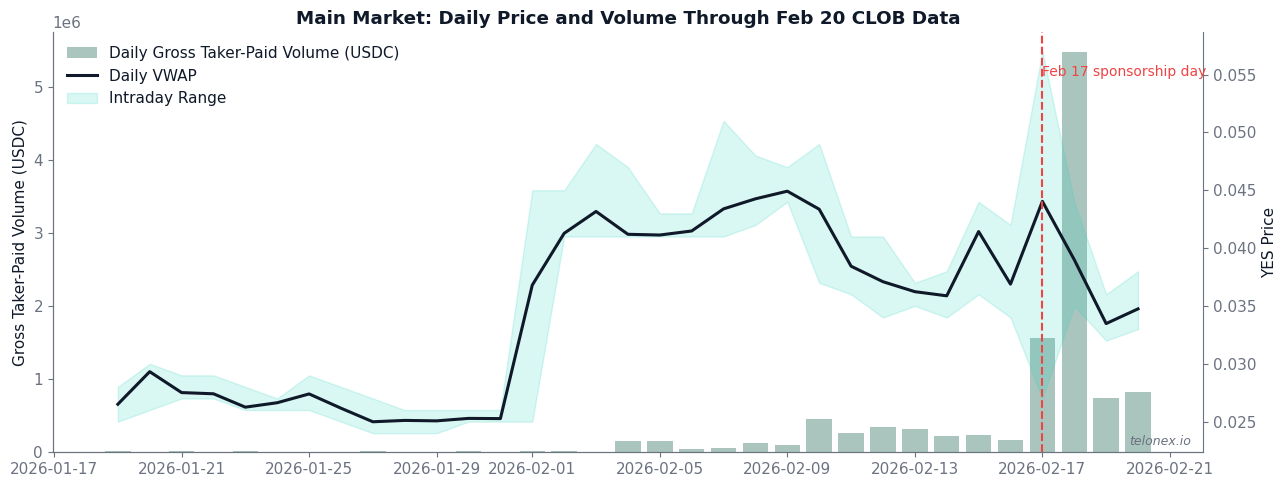

In [19]:
fig, ax1 = plt.subplots(figsize=(13, 5))

d = daily_price.join(daily_fills, how='left')
x = pd.to_datetime(d.index)

ax1.bar(x, d['onchain_volume'], color=TEAL, alpha=0.35, label='Daily Gross Taker-Paid Volume (USDC)')
ax1.set_ylabel('Gross Taker-Paid Volume (USDC)')

ax2 = ax1.twinx()
ax2.plot(x, d['vwap'], color=DARK, linewidth=2.2, label='Daily VWAP')
ax2.fill_between(x, d['min_price'], d['max_price'], color=CYAN, alpha=0.18, label='Intraday Range')
ax2.set_ylabel('YES Price')

ax2.axvline(pd.Timestamp('2026-02-17', tz='UTC'), color=RED, linestyle='--', linewidth=1.5)
ax2.text(pd.Timestamp('2026-02-17', tz='UTC'), d['max_price'].max() * 0.98, 'Feb 17 sponsorship day', color=RED, ha='left', va='top', fontsize=10)

ax1.set_title('Main Market: Daily Price and Volume Through Feb 20 CLOB Data', fontweight='bold', color=DARK)
style_ax(ax1)
ax2.spines['top'].set_visible(False)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, frameon=False, loc='upper left')

plt.tight_layout()
fig.savefig(OUT / 'price_volume_regime.png', dpi=180, bbox_inches='tight')
plt.show()

## Structural Break: Feb 17

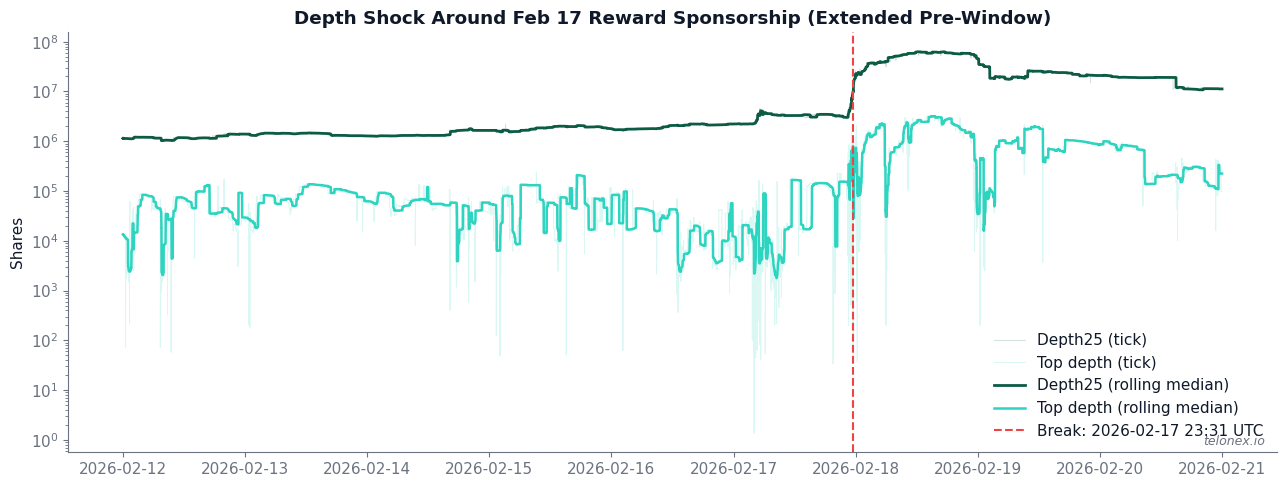

In [20]:
fig, ax = plt.subplots(figsize=(13, 5))

h = book_main[(book_main['timestamp'] >= pd.Timestamp('2026-02-12', tz='UTC')) & (book_main['timestamp'] < pd.Timestamp('2026-02-21', tz='UTC'))].copy()
h = h.sort_values('timestamp')
h['depth25_smooth'] = h['depth25'].rolling(600, min_periods=1).median()
h['top_depth_smooth'] = h['top_depth'].rolling(600, min_periods=1).median()

ax.plot(h['timestamp'], h['depth25'], color=TEAL, alpha=0.18, linewidth=0.7, label='Depth25 (tick)')
ax.plot(h['timestamp'], h['top_depth'], color=CYAN, alpha=0.18, linewidth=0.7, label='Top depth (tick)')
ax.plot(h['timestamp'], h['depth25_smooth'], color=TEAL, linewidth=2.0, label='Depth25 (rolling median)')
ax.plot(h['timestamp'], h['top_depth_smooth'], color=CYAN, linewidth=1.8, label='Top depth (rolling median)')
ax.axvline(event_ts, color=RED, linestyle='--', linewidth=1.5, label=f'Break: {event_ts.strftime("%Y-%m-%d %H:%M UTC")}')

ax.set_title('Depth Shock Around Feb 17 Reward Sponsorship (Extended Pre-Window)', fontweight='bold', color=DARK)
ax.set_ylabel('Shares')
ax.set_yscale('log')
ax.legend(frameon=False)
style_ax(ax)

plt.tight_layout()
fig.savefig(OUT / 'reward_event_timeline.png', dpi=180, bbox_inches='tight')
plt.show()

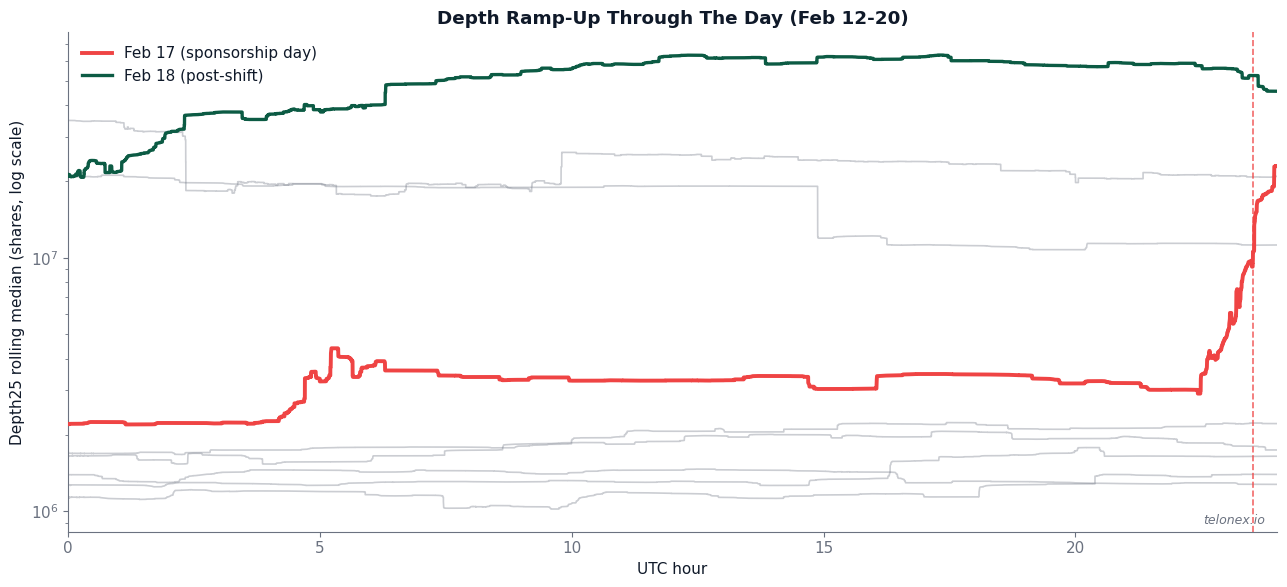

In [21]:
# Depth ramp-up through the day over a longer range
fig, ax = plt.subplots(figsize=(13, 6))
days = pd.date_range('2026-02-12', '2026-02-20', freq='D', tz='UTC')

for d in days:
    g = book_main[(book_main['timestamp'] >= d) & (book_main['timestamp'] < d + pd.Timedelta(days=1))].sort_values('timestamp').copy()
    if len(g) < 50:
        continue
    g['depth_smooth'] = g['depth25'].rolling(400, min_periods=1).median()
    g['hour_of_day'] = g['timestamp'].dt.hour + g['timestamp'].dt.minute / 60.0 + g['timestamp'].dt.second / 3600.0

    day_str = d.strftime('%Y-%m-%d')
    if day_str == '2026-02-17':
        ax.plot(g['hour_of_day'], g['depth_smooth'], color=RED, linewidth=2.8, label='Feb 17 (sponsorship day)', zorder=5)
    elif day_str == '2026-02-18':
        ax.plot(g['hour_of_day'], g['depth_smooth'], color=TEAL, linewidth=2.4, label='Feb 18 (post-shift)', zorder=4)
    else:
        ax.plot(g['hour_of_day'], g['depth_smooth'], color=MUTED, alpha=0.35, linewidth=1.2)

ax.axvline(event_ts.hour + event_ts.minute / 60.0, color=RED, linestyle='--', linewidth=1.2, alpha=0.8)
ax.set_xlim(0, 24)
ax.set_yscale('log')
ax.set_xlabel('UTC hour')
ax.set_ylabel('Depth25 rolling median (shares, log scale)')
ax.set_title('Depth Ramp-Up Through The Day (Feb 12-20)', fontweight='bold', color=DARK)
ax.legend(frameon=False, loc='upper left')
style_ax(ax)

plt.tight_layout()
fig.savefig(OUT / 'depth_rampup_hero.png', dpi=180, bbox_inches='tight')
plt.show()

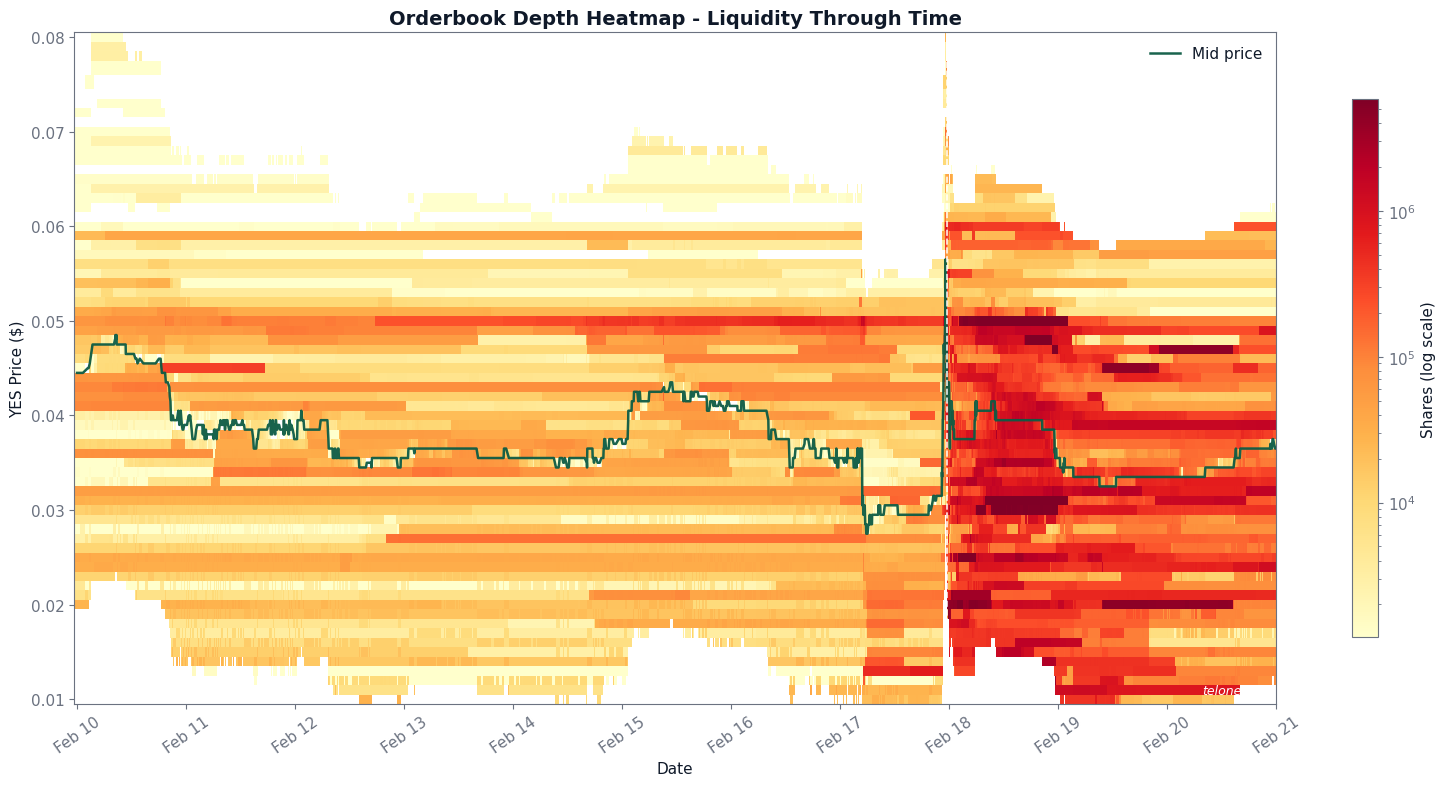

In [22]:
# Depth heatmap: price levels over time with warm palette and mid overlay.
hw = book_main[(book_main['timestamp'] >= pd.Timestamp('2026-02-10', tz='UTC')) & (book_main['timestamp'] < pd.Timestamp('2026-02-21', tz='UTC'))].sort_values('timestamp').copy()
if len(hw) > 2600:
    idx = np.linspace(0, len(hw) - 1, 2600).astype(int)
    hw = hw.iloc[idx].copy()

depth_records = []
cols = [f'{side}_{field}_{i}' for i in range(25) for side in ['bid', 'ask'] for field in ['price', 'size']]
for row in hw[['timestamp'] + cols].itertuples(index=False):
    ts = row[0]
    for i in range(25):
        bp = row[1 + i * 4 + 0]
        bs = row[1 + i * 4 + 1]
        ap = row[1 + i * 4 + 2]
        ass = row[1 + i * 4 + 3]
        if pd.notna(bp) and pd.notna(bs) and bs > 0 and 0.01 <= bp <= 0.08:
            depth_records.append((ts, round(float(bp), 3), float(bs)))
        if pd.notna(ap) and pd.notna(ass) and ass > 0 and 0.01 <= ap <= 0.08:
            depth_records.append((ts, round(float(ap), 3), float(ass)))

depth_df = pd.DataFrame(depth_records, columns=['timestamp', 'price', 'size'])
if depth_df.empty:
    print('No depth records available for heatmap window.')
else:
    heatmap_data = depth_df.pivot_table(
        index='price',
        columns='timestamp',
        values='size',
        aggfunc='sum',
        fill_value=0.0,
    ).sort_index(ascending=True)

    vals = heatmap_data.values
    pos_vals = vals[vals > 0]
    vmin = np.percentile(pos_vals, 5) if len(pos_vals) else 10
    vmax = np.percentile(pos_vals, 99.5) if len(pos_vals) else 1000
    vmin = max(vmin, 10)
    vmax = max(vmax, vmin * 5)

    fig, ax = plt.subplots(figsize=(16, 8))
    im = ax.pcolormesh(
        heatmap_data.columns,
        heatmap_data.index,
        heatmap_data.values,
        cmap='YlOrRd',
        norm=LogNorm(vmin=vmin, vmax=vmax),
        shading='auto',
    )

    mid = (hw['bid_price_0'] + hw['ask_price_0']) / 2
    ax.plot(hw['timestamp'], mid, color=TEAL, lw=1.8, alpha=0.95, label='Mid price')
    ax.axvline(event_ts, color='white', linestyle='--', linewidth=1.2, alpha=0.9)

    ax.set_ylabel('YES Price ($)')
    ax.set_xlabel('Date')
    ax.set_title('Orderbook Depth Heatmap - Liquidity Through Time', fontweight='bold', color=DARK, fontsize=14)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.xticks(rotation=35)
    ax.legend(loc='upper right', frameon=False)

    cbar = plt.colorbar(im, ax=ax, label='Shares at Price Level', shrink=0.8)
    cbar.set_label('Shares (log scale)')
    ax.text(0.99, 0.01, 'telonex.io', transform=ax.transAxes, ha='right', va='bottom', fontsize=9, color='white', style='italic')

    plt.tight_layout()
    fig.savefig(OUT / 'depth_heatmap_event.png', dpi=180, bbox_inches='tight', facecolor='white')
    plt.show()

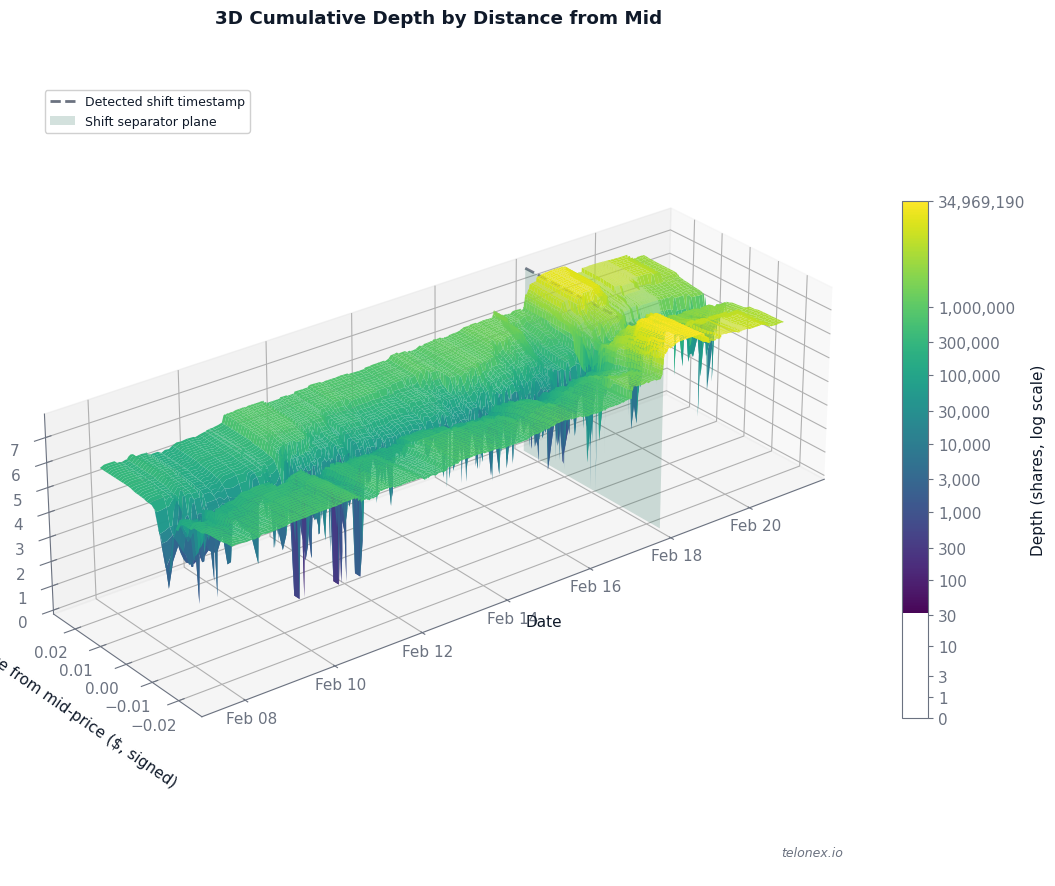

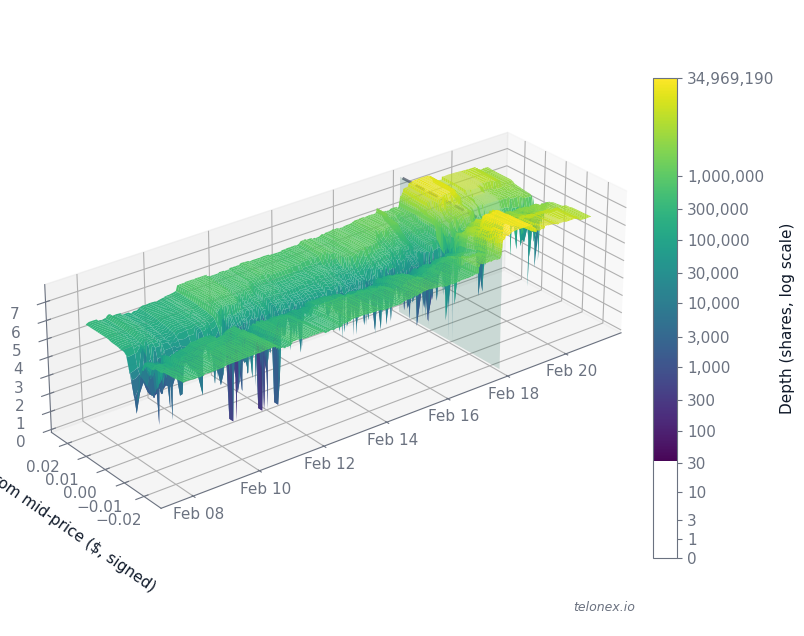

In [23]:
# 3D cumulative signed-level depth surface (shares), with transparent break separator.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

h3 = book_main[
    (book_main['timestamp'] >= pd.Timestamp('2026-02-08', tz='UTC')) &
    (book_main['timestamp'] < pd.Timestamp('2026-02-21', tz='UTC'))
].sort_values('timestamp').copy()

if len(h3) > 900:
    idx = np.linspace(0, len(h3) - 1, 900).astype(int)
    h3 = h3.iloc[idx].copy()

if h3.empty:
    print('No depth records available for 3D surface window.')
else:
    # Build cumulative depth by signed distance from mid-price (in dollars).
    bid_p = h3[[f'bid_price_{i}' for i in range(25)]].to_numpy(dtype=float)
    ask_p = h3[[f'ask_price_{i}' for i in range(25)]].to_numpy(dtype=float)
    bid_s = h3[[f'bid_size_{i}' for i in range(25)]].to_numpy(dtype=float)
    ask_s = h3[[f'ask_size_{i}' for i in range(25)]].to_numpy(dtype=float)
    mid = (h3['bid_price_0'].to_numpy(dtype=float) + h3['ask_price_0'].to_numpy(dtype=float)) / 2.0

    dist_step = 0.001
    dist_bins = np.arange(dist_step, 0.025 + 1e-12, dist_step)
    bid_cum = np.zeros((len(dist_bins), len(h3)), dtype=float)
    ask_cum = np.zeros((len(dist_bins), len(h3)), dtype=float)

    for j in range(len(h3)):
        bd = mid[j] - bid_p[j]
        ad = ask_p[j] - mid[j]
        bs = bid_s[j]
        ass = ask_s[j]

        bmask = np.isfinite(bd) & np.isfinite(bs) & (bs > 0) & (bd >= 0)
        amask = np.isfinite(ad) & np.isfinite(ass) & (ass > 0) & (ad >= 0)
        bd = bd[bmask]
        bs = bs[bmask]
        ad = ad[amask]
        ass = ass[amask]

        for k, d in enumerate(dist_bins):
            bid_cum[k, j] = bs[bd <= d + 1e-12].sum() if len(bs) else 0.0
            ask_cum[k, j] = ass[ad <= d + 1e-12].sum() if len(ass) else 0.0

    y = np.r_[-dist_bins[::-1], dist_bins]
    z_raw = np.vstack([bid_cum[::-1, :], ask_cum])

    x = mdates.date2num(pd.to_datetime(h3['timestamp'], utc=True).dt.tz_localize(None).to_numpy())
    X, Y = np.meshgrid(x, y)

    z_cap = np.percentile(z_raw[z_raw > 0], 99.5) if (z_raw > 0).any() else 1.0
    z_plot = np.log10(1.0 + np.clip(z_raw, 0, z_cap))

    marker_height = float(np.nanmax(z_plot) * 1.03) if np.nanmax(z_plot) > 0 else 1.0
    x_event = mdates.date2num(pd.Timestamp(event_ts).to_pydatetime())
    yp = np.array([[float(y.min()), float(y.max())], [float(y.min()), float(y.max())]])
    zp = np.array([[0.0, 0.0], [marker_height, marker_height]])
    xp = np.full((2, 2), x_event, dtype=float)

    def render_surface(path, figsize=(16, 9), title='3D Cumulative Depth by Distance from Mid', with_legend=True, with_cbar=True, tight=True, wide=False):
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')
        ax.set_facecolor('white')

        surface = ax.plot_surface(
            X,
            Y,
            z_plot,
            cmap='viridis',
            linewidth=0,
            antialiased=True,
            alpha=0.98,
            rcount=min(120, z_plot.shape[0]),
            ccount=min(420, z_plot.shape[1]),
        )

        ax.plot([x_event, x_event], [float(y.min()), float(y.max())], [marker_height, marker_height], color=MUTED, lw=2.0, linestyle='--', alpha=0.9)
        ax.plot_surface(xp, yp, zp, color=TEAL, alpha=0.18, linewidth=0, shade=False)

        ax.set_xlabel('Date', labelpad=10)
        ax.set_ylabel('Distance from mid-price ($, signed)', labelpad=8)
        ax.set_zlabel('Depth (log scale)', labelpad=8)
        if title:
            ax.set_title(title, pad=14, fontweight='bold', color=DARK)
        ax.view_init(elev=27, azim=-128)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        if wide:
            ax.set_xlabel('')
            ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
        try:
            ax.set_box_aspect((3.6, 1.15, 1.0))
        except Exception:
            pass
        if wide:
            # Fill more of the wide canvas without changing surface geometry.
            # Leave a slim right gutter only when colorbar is enabled.
            if with_cbar:
                ax.set_position([0.00, 0.03, 0.94, 0.95])
            else:
                ax.set_position([0.00, 0.03, 0.99, 0.95])

        if with_legend:
            legend_items = [
                Line2D([0], [0], color=MUTED, linestyle='--', linewidth=2, label='Detected shift timestamp'),
                Patch(facecolor=TEAL, edgecolor='none', alpha=0.18, label='Shift separator plane'),
            ]
            ax.legend(
                handles=legend_items,
                loc='upper left',
                bbox_to_anchor=(0.02, 0.95),
                frameon=True,
                framealpha=0.92,
                fontsize=9,
                borderpad=0.4,
            )

        if with_cbar:
            if wide:
                cbar = fig.colorbar(surface, ax=ax, pad=0.006, fraction=0.016, shrink=0.78)
            else:
                cbar = fig.colorbar(surface, ax=ax, shrink=0.62, pad=0.03)
            share_anchors = np.array([0, 1, 3, 10, 30, 100, 300, 1_000, 3_000, 10_000, 30_000, 100_000, 300_000, 1_000_000], dtype=float)
            share_ticks = share_anchors[share_anchors <= z_cap]
            if len(share_ticks) == 0 or share_ticks[-1] < z_cap:
                share_ticks = np.r_[share_ticks, z_cap]
            cbar.set_ticks(np.log10(1.0 + share_ticks))
            cbar.set_ticklabels([f'{int(round(v)):,}' for v in share_ticks])
            cbar.set_label('Depth (shares, log scale)')

        ax.text2D(0.985, 0.02, 'telonex.io', transform=ax.transAxes, ha='right', va='bottom', fontsize=9, color=MUTED, style='italic')

        if tight:
            plt.tight_layout()
            fig.savefig(path, dpi=220, bbox_inches='tight', pad_inches=0.2, facecolor='white')
        else:
            fig.savefig(path, dpi=220, facecolor='white')
        plt.show()

    # Full analytical version.
    render_surface(
        OUT / 'depth_surface_3d_hero.png',
        figsize=(16, 9),
        title='3D Cumulative Depth by Distance from Mid',
        with_legend=True,
        with_cbar=True,
    )

    # Wide 5:2 version: render, then auto-center + scale on a fixed canvas.
    x_raw = OUT / 'depth_surface_3d_hero_x_raw.png'
    render_surface(
        x_raw,
        figsize=(20, 8),
        title='',
        with_legend=False,
        with_cbar=True,
        tight=False,
        wide=True,
    )

    from PIL import Image
    arr = np.array(Image.open(x_raw).convert('RGB'))
    bg = arr[0, 0].astype('int16')
    delta = np.abs(arr.astype('int16') - bg).sum(axis=2)
    mask = delta > 8
    ys, xs = np.where(mask)
    if len(xs) > 0 and len(ys) > 0:
        x0, x1 = xs.min(), xs.max() + 1
        y0, y1 = ys.min(), ys.max() + 1
        pad = 12
        x0 = max(0, x0 - pad)
        y0 = max(0, y0 - pad)
        x1 = min(arr.shape[1], x1 + pad)
        y1 = min(arr.shape[0], y1 + pad)
        crop = Image.fromarray(arr[y0:y1, x0:x1], mode='RGB')
    else:
        crop = Image.open(x_raw).convert('RGB')

    target_w, target_h = 5000, 2000  # exact 5:2
    scale = min((target_w * 0.97) / crop.width, (target_h * 0.94) / crop.height)
    new_size = (max(1, int(round(crop.width * scale))), max(1, int(round(crop.height * scale))))
    try:
        resample = Image.Resampling.LANCZOS
    except Exception:
        resample = Image.LANCZOS
    resized = crop.resize(new_size, resample=resample)

    canvas = Image.new('RGB', (target_w, target_h), (255, 255, 255))
    ox = (target_w - resized.width) // 2
    oy = (target_h - resized.height) // 2
    canvas.paste(resized, (ox, oy))
    canvas.save(OUT / 'depth_surface_3d_hero_x.png')

    try:
        x_raw.unlink()
    except Exception:
        pass

## Microstructure Shift

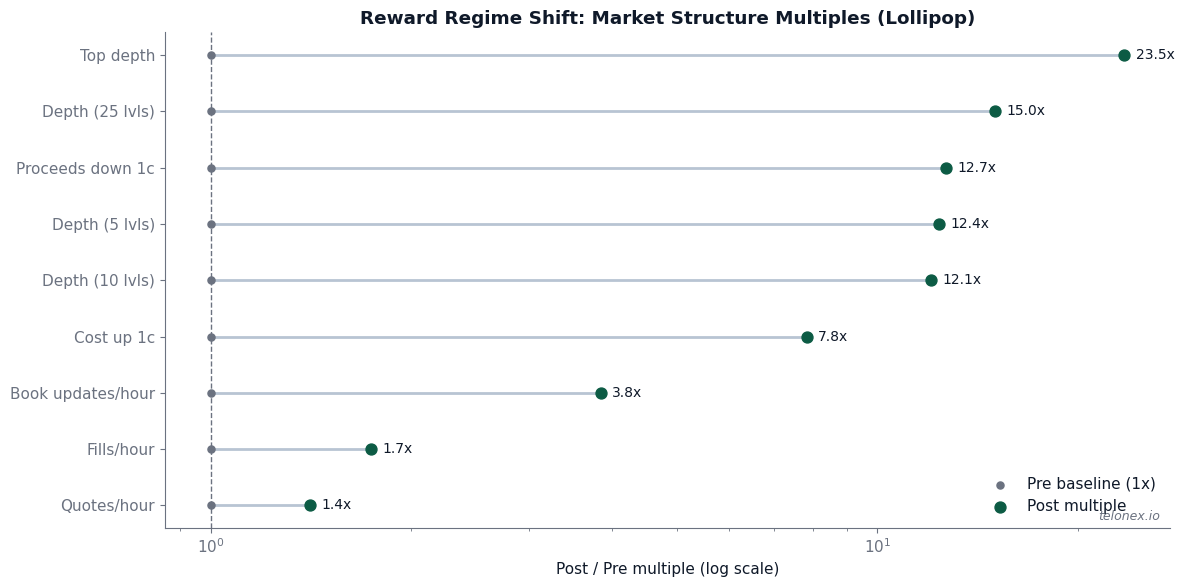

In [24]:
base = regime_summary.iloc[0]
comp = regime_summary.iloc[1]

metric_rows = [
    ('Top depth', comp['median_top_depth'] / base['median_top_depth']),
    ('Depth (5 lvls)', comp['median_depth5'] / base['median_depth5']),
    ('Depth (10 lvls)', comp['median_depth10'] / base['median_depth10']),
    ('Depth (25 lvls)', comp['median_depth25'] / base['median_depth25']),
    ('Cost up 1c', comp['median_cost_up_1c'] / base['median_cost_up_1c']),
    ('Proceeds down 1c', comp['median_proc_down_1c'] / base['median_proc_down_1c']),
    ('Fills/hour', comp['fills_per_hour'] / base['fills_per_hour']),
    ('Quotes/hour', comp['quotes_per_hour'] / base['quotes_per_hour']),
    ('Book updates/hour', comp['book_updates_per_hour'] / base['book_updates_per_hour']),
]
mdf = pd.DataFrame(metric_rows, columns=['metric', 'multiple']).sort_values('multiple')
y = np.arange(len(mdf))

fig, ax = plt.subplots(figsize=(12, 6))
ax.hlines(y, 1.0, mdf['multiple'], color='#B8C4D3', linewidth=2)
ax.scatter(np.full(len(y), 1.0), y, color=MUTED, s=26, zorder=3, label='Pre baseline (1x)')
ax.scatter(mdf['multiple'], y, color=TEAL, s=62, zorder=4, label='Post multiple')
for yi, mv in zip(y, mdf['multiple']):
    ax.text(mv * 1.04, yi, f'{mv:.1f}x', va='center', ha='left', fontsize=10)

ax.set_yticks(y)
ax.set_yticklabels(mdf['metric'])
ax.set_xscale('log')
ax.axvline(1.0, color=MUTED, linestyle='--', linewidth=1)
ax.set_xlabel('Post / Pre multiple (log scale)')
ax.set_title('Reward Regime Shift: Market Structure Multiples (Lollipop)', fontweight='bold', color=DARK)
ax.legend(frameon=False, loc='lower right')
style_ax(ax)
plt.tight_layout()
fig.savefig(OUT / 'liquidity_regime_multiples.png', dpi=180, bbox_inches='tight')
plt.show()

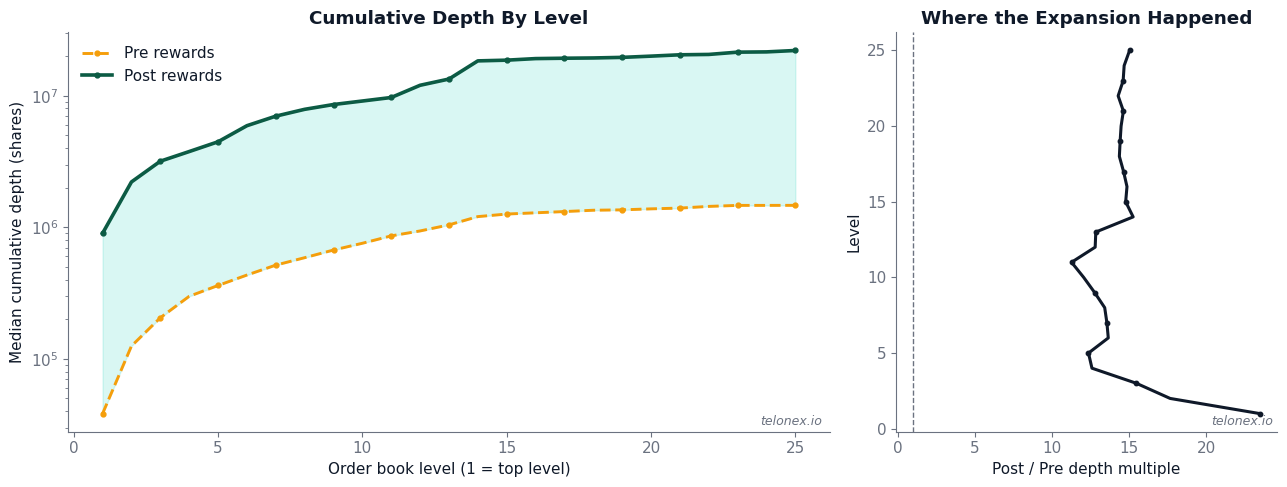

In [25]:
dc = depth_curve.copy()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5), gridspec_kw={'width_ratios': [2, 1]})

ax1.plot(dc['level'], dc['pre_depth'], color=AMBER, linewidth=2.1, linestyle='--', marker='o', markersize=3.5, markevery=2, label='Pre rewards')
ax1.plot(dc['level'], dc['post_depth'], color=TEAL, linewidth=2.6, marker='o', markersize=3.5, markevery=2, label='Post rewards')
ax1.fill_between(dc['level'], dc['pre_depth'], dc['post_depth'], where=(dc['post_depth'] >= dc['pre_depth']), color=CYAN, alpha=0.18)
ax1.set_xlabel('Order book level (1 = top level)')
ax1.set_ylabel('Median cumulative depth (shares)')
ax1.set_yscale('log')
ax1.set_title('Cumulative Depth By Level', fontweight='bold', color=DARK)
ax1.legend(frameon=False, loc='upper left')
style_ax(ax1)

ax2.plot(dc['multiple'], dc['level'], color=DARK, linewidth=2.2, marker='o', markersize=3.2, markevery=2)
ax2.axvline(1.0, color=MUTED, linestyle='--', linewidth=1)
ax2.set_xlabel('Post / Pre depth multiple')
ax2.set_ylabel('Level')
ax2.set_title('Where the Expansion Happened', fontweight='bold', color=DARK)
style_ax(ax2)

plt.tight_layout()
fig.savefig(OUT / 'depth_curve_shift.png', dpi=180, bbox_inches='tight')
plt.show()

## Execution by USDC Budget

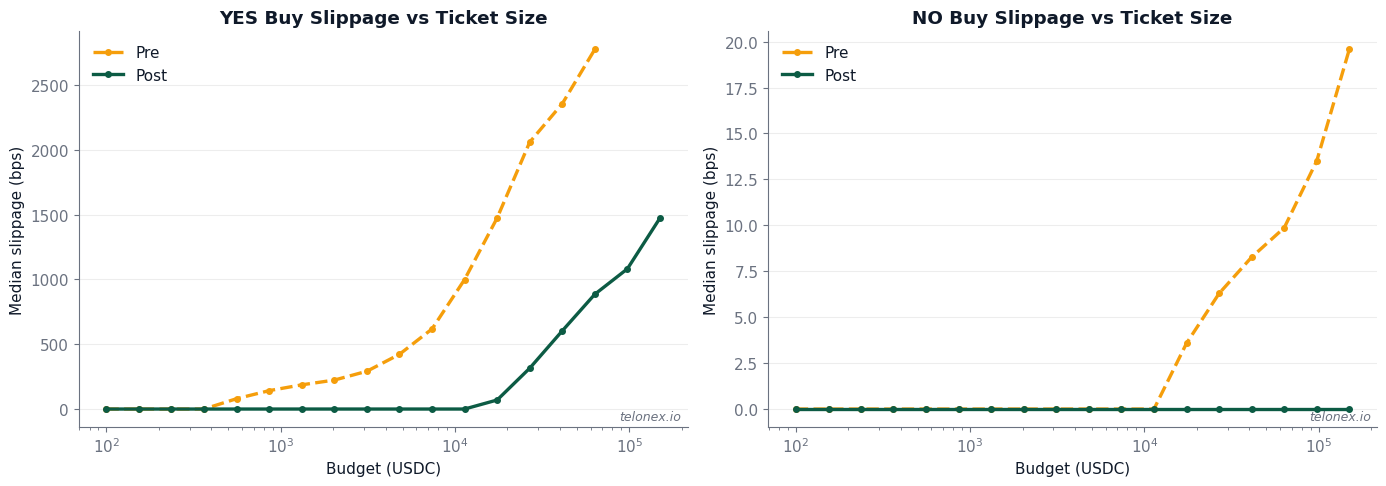

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

es = exec_summary.sort_values(['budget_usdc', 'regime']).copy()
min_obs_share = 0.05  # avoid noisy tail where 25-level snapshots rarely fill ticket.

for regime, color, ls in [('pre', AMBER, '--'), ('post', TEAL, '-')]:
    s = es[es['regime'] == regime].copy()

    yes = s[(s['yes_obs_share'] >= min_obs_share) & np.isfinite(s['yes_buy_slippage_bps'])]
    no = s[(s['no_obs_share'] >= min_obs_share) & np.isfinite(s['no_buy_slippage_bps'])]

    ax1.plot(yes['budget_usdc'], yes['yes_buy_slippage_bps'], color=color, linewidth=2.4, linestyle=ls, marker='o', markersize=4, label=f'{regime.title()}')
    ax2.plot(no['budget_usdc'], no['no_buy_slippage_bps'], color=color, linewidth=2.4, linestyle=ls, marker='o', markersize=4, label=f'{regime.title()}')

ax1.set_xscale('log')
ax1.set_title('YES Buy Slippage vs Ticket Size', fontweight='bold', color=DARK)
ax1.set_ylabel('Median slippage (bps)')
ax1.set_xlabel('Budget (USDC)')
ax1.legend(frameon=False, loc='upper left')
style_ax(ax1)

ax2.set_xscale('log')
ax2.set_title('NO Buy Slippage vs Ticket Size', fontweight='bold', color=DARK)
ax2.set_ylabel('Median slippage (bps)')
ax2.set_xlabel('Budget (USDC)')
ax2.legend(frameon=False, loc='upper left')
style_ax(ax2)

for ax in [ax1, ax2]:
    ax.grid(True, axis='y', alpha=0.22, linewidth=0.8)

plt.tight_layout()
fig.savefig(OUT / 'execution_ticket_slippage.png', dpi=180, bbox_inches='tight')
plt.show()

## Maker and Wallet Behavior

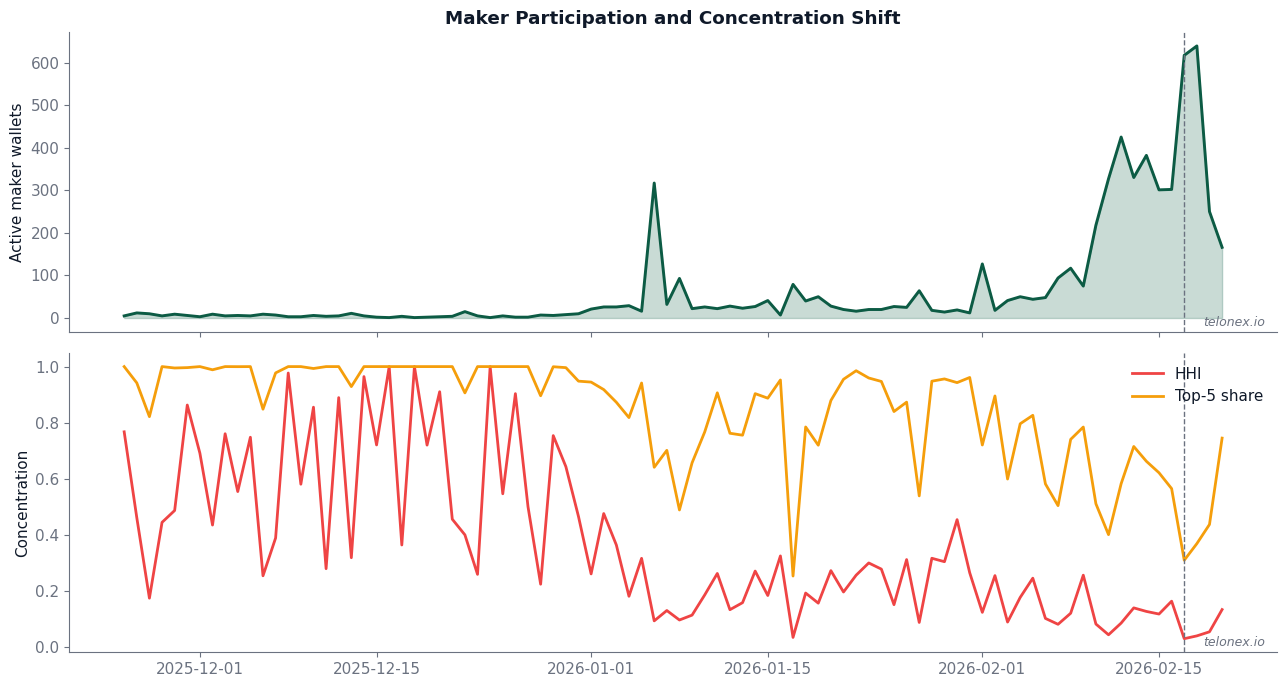

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 7), sharex=True)
x = pd.to_datetime(maker_conc.index)

ax1.fill_between(x, 0, maker_conc['maker_count'], color=TEAL, alpha=0.22)
ax1.plot(x, maker_conc['maker_count'], color=TEAL, linewidth=2.1)
ax1.axvline(pd.Timestamp('2026-02-17', tz='UTC'), color=MUTED, linestyle='--', linewidth=1)
ax1.set_ylabel('Active maker wallets')
ax1.set_title('Maker Participation and Concentration Shift', fontweight='bold', color=DARK)
style_ax(ax1)

ax2.plot(x, maker_conc['hhi'], color=RED, linewidth=2, label='HHI')
ax2.plot(x, maker_conc['top5_share'], color=AMBER, linewidth=2, label='Top-5 share')
ax2.axvline(pd.Timestamp('2026-02-17', tz='UTC'), color=MUTED, linestyle='--', linewidth=1)
ax2.set_ylabel('Concentration')
ax2.legend(frameon=False, loc='upper right')
style_ax(ax2)

plt.tight_layout()
fig.savefig(OUT / 'maker_concentration_shift.png', dpi=180, bbox_inches='tight')
plt.show()

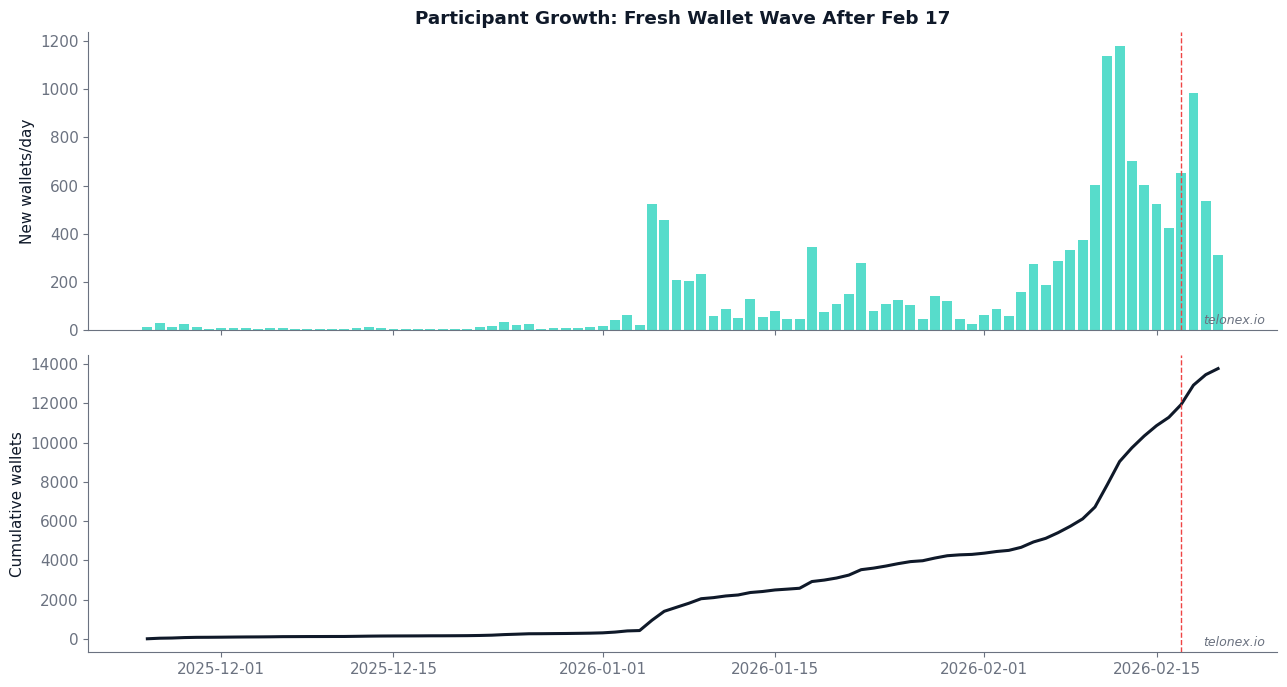

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 7), sharex=True)

nw = new_wallets_daily.copy()
x = pd.to_datetime(nw.index)

ax1.bar(x, nw['new_wallets'], color=CYAN, alpha=0.8)
ax1.axvline(pd.Timestamp('2026-02-17', tz='UTC'), color=RED, linestyle='--', linewidth=1)
ax1.set_ylabel('New wallets/day')
ax1.set_title('Participant Growth: Fresh Wallet Wave After Feb 17', fontweight='bold', color=DARK)
style_ax(ax1)

ax2.plot(x, nw['cum_wallets'], color=DARK, linewidth=2.2)
ax2.axvline(pd.Timestamp('2026-02-17', tz='UTC'), color=RED, linestyle='--', linewidth=1)
ax2.set_ylabel('Cumulative wallets')
style_ax(ax2)

plt.tight_layout()
fig.savefig(OUT / 'wallet_growth_wave.png', dpi=180, bbox_inches='tight')
plt.show()

## Notes

- All findings are auto-computed from data on each run.
- Charts are saved to `output/`.
- See the full write-up at [telonex.io/research/sponsored-liquidity-rewards-jesus-market](https://telonex.io/research/sponsored-liquidity-rewards-jesus-market).